The following is a decision tree approach to trade data supplied by Jane Street in a Kaggle Machine Learning competition: https://www.kaggle.com/c/jane-street-market-prediction
There are 130 anonymized, normalized features for each row of data respresenting possible trades. The return over various time horizons is also supplied, as well as weights for each trade. Using machine learning, the aim is to create an online version of an algorithm created with the test data. 
Due to the immense size of the dataset, I will be using kdb in my exploratory analysis and model selection/fitting.

In [1]:
\c 100 100
\cd C:\q\w32\

/ Import Python libraries
\l p.q
/import several ml libraries
\l quantQ\lib\quantQjupyterq.q
\l mlnotebooks\utils\graphics.q
\l automl\automl.q


\l ml\ml.q

\l mlnotebooks\utils\graphics.q
\l mlnotebooks\utils\util.q
/Fun Q ml library
\l funq\funqJQ.q
/graphing 
\l embedPy\examples\importmatplotlib.q
plt:.matplotlib.pyplot[]



Welcome to quantQ
   ____ \ \   
  / ___| \ \  
 | |_| |  ) )   
  \__  | / /   
     |_|/ /     

For available sub-namespaces, type key`.quantQ:
()

For functions in a namespace, type .e.g \f .quantQ.rf



In [2]:
//A True/false table is given for our 130 features
features:("SSSSSSSSSSSSSSSSSSSSSSSSSSSSSS";enlist",") 0: `:C:/MLProjects/JaneStreetMarketPrediction/features.csv
features:(select feature from features) ,'(flip 1_flip features = `TRUE)
`feature xkey `features 
features:"f"$features
show 10#features

//1 for true, 0 for false

feature  | tag_0 tag_1 tag_2 tag_3 tag_4 tag_5 tag_6 tag_7 tag_8 tag_9 tag_10 tag_11 tag_12 tag_1..
---------| --------------------------------------------------------------------------------------..
feature_0| 0     0     0     0     0     0     0     0     0     0     0      0      0      0    ..
feature_1| 0     0     0     0     0     0     1     1     0     0     0      0      0      0    ..
feature_2| 0     0     0     0     0     0     1     1     0     1     0      0      0      0    ..
feature_3| 0     0     0     0     0     0     1     0     1     0     0      0      0      0    ..
feature_4| 0     0     0     0     0     0     1     0     1     1     0      0      0      0    ..
feature_5| 0     0     0     0     0     0     1     0     0     0     1      0      0      0    ..
feature_6| 0     0     0     0     0     0     1     0     0     1     1      0      0      0    ..
feature_7| 0     0     0     0     1     0     1     0     0     0     0      1      0      0    ..


`features


In [3]:
//load 500 days of trade data
t:("FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF";enlist",") 0: `:C:/MLProjects/JaneStreetMarketPrediction/train.csv

In [4]:
//key the table based on date
`date xkey `t
//apply sort attribute on tablee t
`s#t;

`t


In [59]:
//I wish to see the cumulative behavior of the asset and the corresponding features

sumTable:((sum select from t where date = 0);(sum select from t where date = 1))
`sumTable upsert (sum select from t where date = 3);
`sumTable upsert (sum select from t where date = 4);
`sumTable upsert (sum select from t where date = 5);
`sumTable upsert (sum select from t where date = 6);
`sumTable upsert (sum select from t where date = 7);
`sumTable upsert (sum select from t where date = 8);
`sumTable upsert (sum select from t where date = 9);
`sumTable upsert (sum select from t where date = 10);
`sumTable upsert (sum select from t where date = 11);
`sumTable upsert (sum select from t where date = 12);
`sumTable upsert (sum select from t where date = 13);
`sumTable upsert (sum select from t where date = 14);
`sumTable upsert (sum select from t where date = 15);
`sumTable upsert (sum select from t where date = 16);
`sumTable upsert (sum select from t where date = 17);
`sumTable upsert (sum select from t where date = 18);
`sumTable upsert (sum select from t where date = 19);
`sumTable upsert (sum select from t where date = 20);
`sumTable upsert (sum select from t where date = 21);
`sumTable upsert (sum select from t where date = 22);
`sumTable upsert (sum select from t where date = 23);
`sumTable upsert (sum select from t where date = 24);
`sumTable upsert (sum select from t where date = 25);
`sumTable upsert (sum select from t where date = 26);
`sumTable upsert (sum select from t where date = 27);
`sumTable upsert (sum select from t where date = 28);
`sumTable upsert (sum select from t where date = 29);
`sumTable upsert (sum select from t where date = 30);

sumTable

In [6]:
desc u cor/:\:u:flip sumTable
//If we assume cumulative weight is a measure of trading activity, then features 19, 64, 41, 25, 107... correlate with vol

           | weight    resp_1      resp_2      resp_3      resp_4       resp        feature_0   f..
------     | ------------------------------------------------------------------------------------..
weight     | 1         0.6502968   0.528533    0.3907316   0.2438018    0.2132593   0.2166088   0..
feature_19 | 0.872508  0.6556457   0.5557137   0.4160078   0.2823856    0.2553343   0.5737334   0..
feature_64 | 0.8711671 0.4586867   0.3349088   0.2106426   0.1041159    0.08065981  0.336871    0..
feature_41 | 0.8677441 0.7555867   0.6386575   0.4018487   0.2784457    0.2846957   0.1667631   0..
feature_25 | 0.8597158 0.6307746   0.5306731   0.3980631   0.2615406    0.2317849   0.605812    0..
feature_107| 0.8400914 0.57538     0.4568117   0.2237389   0.09752889   0.09834594  0.3041786   0..
feature_95 | 0.8344078 0.5379437   0.4054576   0.1679591   0.03998059   0.03881176  0.2824864   0..
feature_119| 0.8323594 0.554094    0.430159    0.1932024   0.06658764   0.06732719  0.3017375   0..


In [7]:
sum select resp_1,resp_2,resp_3,resp_4 from sumTable
//we see on average that the longer the hold the more profit. 

resp_1| 63.86883
resp_2| 76.54616
resp_3| 159.4412
resp_4| 269.699


In [8]:
count select from t where resp_1 >0, resp<0
count select from t where resp_1 <0, resp>0

428573


417952


In [9]:
/
There are plenty of trades that start off negative but end positive and vis versa, almost identical counts
We will not take trades with positive resp. Instead, we take trades with positive resp_1

Rule 1: Don't take any trades with a negative return on 1st time horizon
Rule 2: Don't take trades with weight above X
Rule 3: End model uses online learning
Rule 4: Be prepared for regime change (Identify the change itself, warning signs, and effects)
Rule 5: Feature Engineer lagging indicators

`t


{[f;x]embedPy[f;x]}[foreign]enlist


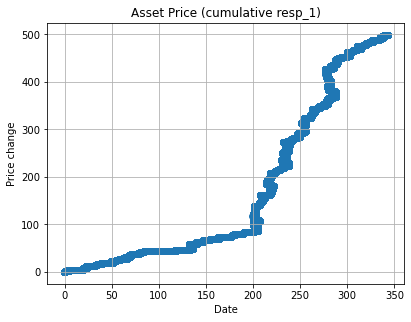

In [10]:
update sumresp:sums resp_1 from `t
plt.xlabel"Date";
plt.ylabel"Price change";
plt.title"Asset Price (cumulative resp_1)";
plt.grid 1b;
plt.scatter[exec sumresp from t;  exec date from t]
plt.show[];

In [11]:
//we see the asset appreciate over time, making most trades profitable
//we will likely see very similar trading days. We will try to cluster trading days together later on

In [12]:
//We analyze the data on a per day basis. 
delete sumresp from `t;
day0t:select from t where date=0


`t


In [13]:
day0t:0!day0t //unkey
delete date, weight, ts_id  from `day0t;

`day0t


In [14]:
update trade:0 from `day0t;
update trade: 1 from `day0t where  resp_1>0;
day0t:`trade xcols day0t

`day0t


`day0t


In [41]:
//Make decision tree to separate, no time series data leakage
d:.ut.part[`train`test!3 1;til] day0t
delete resp_1, resp_2, resp_3, resp_4, resp from `d.train
delete resp_1, resp_2, resp_3, resp_4, resp from `d.test

`d.train


`d.test


In [16]:
//random forest, number features used = sqrt n
k:20
m:.ml.bag[k;.ml.ct[(1#`maxff)!1#sqrt;::]] d.train ///make k decision trees
//random forest sqrt features p171
max avg d.test.trade = .ml.pbag[1+til k;m] d.test

0.52398


In [40]:
//at 52.4%, Random Forests with existing data fail as a binary classifier
//Instead of predicting trade viability using features, we will use the change in features
delta0t:day0t - prev day0t
update trade:(exec trade from day0t) from `delta0t
delta0t:1_delta0t; //drop first row
delta0:.ut.part[`train`test!3 1;til] delta0t
delete resp_1, resp_2, resp_3, resp_4, resp from `delta0.train;
delete resp_1, resp_2, resp_3, resp_4, resp from `delta0.test;

`delta0t


`delta0.train


`delta0.test


In [39]:
//random forest, number features used = sqrt n (using delta of features)
k:20
m:.ml.bag[k;.ml.ct[(1#`maxff)!1#sqrt;::]] delta0.train ///make k decision trees
//random forest sqrt features p171
max avg delta0.test.trade = .ml.pbag[1+til k;m] delta0.test

0.5390122


In [49]:
//Running a random forest on the deltas seems to be fruitless as well. 
//For completeness, we will use adaptive boosting as well.

/partition
count each d:.ut.part[`train`test!3 1;til] day0t
delete resp_1, resp_2, resp_3, resp_4, resp from `d.train;
delete resp_1, resp_2, resp_3, resp_4, resp from `d.test;

/create decision tree stump to use as a weak classifier
stump:.ml.ct[(1#`maxd)!1#1]
-1 .ml.ptree[0] stump[::] d.train

train| 4190
test | 1397


1 (n = 4190, err = 48.9%)
|  feature_39 >[;-0.006013617] 0: 1 (n = 2049, err = 40%)
|  feature_39 >[;-0.006013617] 1: 0 (n = 2141, err = 42.5%)


-1


In [50]:
//Our best feature is feature_39 with a 40% error rate
//We will run 20 rounds of Adaboost and store model in m
k:20
m:.ml.fab[k;stump;.ml.pdt] d.train

In [52]:
//This is computationally expensive. We check for converging k value before testing
P:.ml.pab[1+ til k;.ml.pdt;m] d.train
max avg d.train.trade = P

0.5875895


In [53]:
//At 58.75% accuracy on training data, it would seem adaboost is a poor fit for the feature data
P:.ml.pab[1+ til k;.ml.pdt;m] d.test
max avg d.test.trade = P

0.5382963


In [56]:
//53.82% on test data
//Let us proceed to use the deltas instead
k:20
m:.ml.fab[k;stump;.ml.pdt] delta0.train //train model
//test model on training data
P:.ml.pab[1+ til k;.ml.pdt;m] delta0.train
max avg delta0.train.trade = P

0.5586059


In [58]:
//At 55.86% accuracy on training data is very poor. Let us move on to test
P:.ml.pab[1+ til k;.ml.pdt;m] delta0.test
max avg delta0.test.trade = P

0.5382963


As we have seen, decision tree algorithms such as Random Forest and AdaBoost performed very poorly on the trade data provided by Jane Street. Although I have seen some decision tree algos perform well on tick data, whatever the features on this dataset represent do not lend themselves to such methods.